## Modelowanie ML (klasyfikacja Credit Score)

Celem tego etapu jest porównanie kilku klasycznych modeli uczenia maszynowego dla problemu wieloklasowej klasyfikacji `Credit_Score` oraz wybór najlepszego podejścia na podstawie metryk ewaluacyjnych.

Notebook wykorzystuje dane przygotowane w etapie preprocessingu (`train_clean.csv`). Modele trenowane są w ujednoliconym pipeline (`preprocessing + model`), co zapewnia porównywalność wyników i ogranicza ryzyko wycieku informacji.

Jako główną metrykę ewaluacyjną przyjęto macro F1-score, odpowiednią dla problemu z niezbalansowanym rozkładem klas.

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score

In [2]:
train_df = pd.read_csv("../data/processed/train_clean.csv")

X = train_df.drop(columns='Credit_Score')
y = train_df['Credit_Score']

In [3]:
X_train, X_val, y_train, y_val = train_test_split(
    X,y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

Dane po preprocessingu (`train_clean.csv`) podzielono na zbiory treningowy i walidacyjny w proporcji 80/20. Zastosowano `stratify=y`, aby zachować proporcje klas w obu zbiorach (zmienna docelowa jest niezbalansowana). Parametr `random_state=42` zapewnia powtarzalność wyników.

In [4]:
num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = X.select_dtypes(include=['object','str']).columns

Na potrzeby budowy pipeline’u modelowania cechy podzielono na numeryczne i kategoryczne na podstawie typów danych. Umożliwia to zastosowanie odpowiednich transformacji: skalowania dla cech numerycznych oraz kodowania One-Hot dla cech kategorycznych.

In [5]:
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

Zdefiniowano `ColumnTransformer`, który:
- skaluje cechy numeryczne (`StandardScaler`),
- koduje cechy kategoryczne (`OneHotEncoder(handle_unknown="ignore")`).

Parametr `handle_unknown="ignore"` zabezpiecza pipeline na wypadek pojawienia się nowych kategorii w zbiorze walidacyjnym lub testowym.

In [6]:
print("Numeryczne:", list(num_cols))
print("Kategoryczne:", list(cat_cols))

Numeryczne: ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance', 'Credit_History_Months']
Kategoryczne: ['Month', 'Occupation', 'Type_of_Loan', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']


Kontrolne sprawdzenie, czy wszystkie kolumny zostały właściwie przypisane.

In [8]:
models = {
    "LogReg": LogisticRegression(max_iter=1000, n_jobs=-1),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
}

## Modele bazowe (baseline)

Porównuję kilka klasycznych modeli ML:
- Logistic Regression,
- Random Forest,
- Gradient Boosting

Każdy model będzie trenowany w tym samym pipeline z identycznym preprocessingiem,
co zapewnia uczciwe porównanie wyników.

Dla każdego modelu tworzony jest pełny pipeline składający się z:
- preprocessingu (skalowanie cech numerycznych oraz One-Hot Encoding cech kategorycznych),
- właściwego klasyfikatora.

Modele trenowane są na zbiorze treningowym, a następnie oceniane na zbiorze walidacyjnym.

Jako główną metrykę porównawczą wykorzystuję **macro F1-score**,
ponieważ zmienna docelowa (`Credit_Score`) jest niezbalansowana i zależy mi na równym traktowaniu wszystkich klas.
Dodatkowo dla każdego modelu wyświetlany jest pełny raport klasyfikacji.

In [9]:
results = {}

for name, clf in models.items():
    pipe = Pipeline([
        ("prep", preprocess),
        ("model", clf),
    ])

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_val)

    f1 = f1_score(y_val, preds, average="macro")
    results[name] = f1

    print("\n" + "="*60)
    print(name, "| macro F1:", round(f1, 4))
    print(classification_report(y_val, preds))

C:\Users\mikol\IdeaProjects\CreditScore_AI\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)



LogReg | macro F1: 0.6991
              precision    recall  f1-score   support

        Good       0.60      0.60      0.60      3566
        Poor       0.78      0.69      0.73      5799
    Standard       0.75      0.79      0.77     10635

    accuracy                           0.73     20000
   macro avg       0.71      0.69      0.70     20000
weighted avg       0.73      0.73      0.73     20000


RandomForest | macro F1: 0.7515
              precision    recall  f1-score   support

        Good       0.70      0.69      0.70      3566
        Poor       0.78      0.74      0.76      5799
    Standard       0.78      0.81      0.80     10635

    accuracy                           0.77     20000
   macro avg       0.76      0.75      0.75     20000
weighted avg       0.77      0.77      0.77     20000


GradientBoosting | macro F1: 0.6663
              precision    recall  f1-score   support

        Good       0.59      0.58      0.58      3566
        Poor       0.74      0.6

## Model logistyczny

Stanowi punkt odniesienia (baseline).
Osiąga macro F1-score ≈ 0.69, co wskazuje na umiarkowaną jakość predykcji.

Model radzi sobie najlepiej z klasą „Standard”, natomiast klasa „Good” jest trudniejsza do poprawnej klasyfikacji. Może to wynikać z bardziej złożonych (potencjalnie nieliniowych) zależności w danych, których model liniowy nie jest w stanie w pełni uchwycić.

## Random Forest

Osiąga najlepsze wyniki spośród testowanych modeli (macro F1-score ≈ 0.75).

- lepiej rozróżnia wszystkie trzy klasy,
- szczególnie poprawia wyniki dla klasy „Good”,
- zachowuje wysoką skuteczność dla klasy dominującej „Standard”.

Dzięki swojej nieliniowej naturze oraz agregacji wielu drzew decyzyjnych,
Random Forest lepiej dopasowuje się do złożonych relacji pomiędzy cechami.

## Gradient Boosting

Osiąga najniższy wynik macro F1-score (≈ 0.66).
Model wykazuje gorszą zdolność rozróżniania klas w porównaniu do Random Forest.
Niższy wynik może wynikać m.in. z braku strojenia hiperparametrów oraz większej wrażliwości modelu na ustawienia uczenia.

W obecnej konfiguracji model ten nie przewyższa ani regresji logistycznej, ani Random Forest.

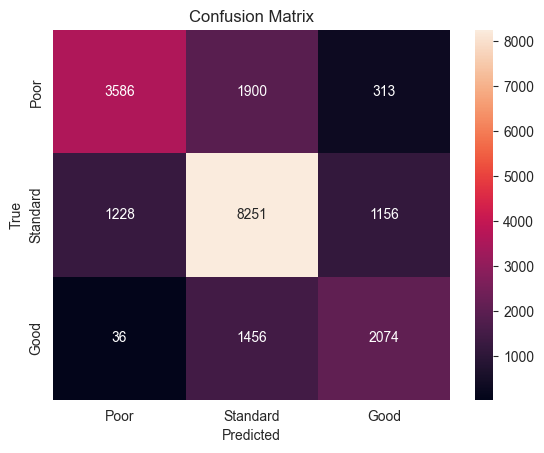

In [10]:
cm = confusion_matrix(y_val, preds, labels=["Poor", "Standard", "Good"])

sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Poor", "Standard", "Good"],
            yticklabels=["Poor", "Standard", "Good"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Powyższa macierz pomyłek dotyczy modelu Random Forest (baseline).

Macierz pomyłek pokazuje, że model najlepiej rozpoznaje klasę **Standard**,
która jest również klasą dominującą w zbiorze danych.

Najczęstsze błędy klasyfikacji występują pomiędzy klasami sąsiadującymi:
- **Poor ↔ Standard**
- **Standard ↔ Good**

Model rzadko myli skrajne klasy (**Poor** i **Good**) bezpośrednio ze sobą,
co sugeruje, że potrafi uchwycić ogólny poziom ryzyka kredytowego,
ale ma trudność w precyzyjnym rozróżnieniu klientów granicznych.

Takie zachowanie jest typowe dla modeli trenowanych na niezbalansowanych danych
i może być pożądane w kontekście ostrożnej oceny ryzyka kredytowego.

In [11]:
acc = accuracy_score(y_val, preds)
print("Accuracy:", round(acc, 4))

Accuracy: 0.6956


Uzyskana dokładność (accuracy) wynosi około 0.70, jednak ze względu na
niezbalansowany rozkład klas nie jest ona główną miarą jakości modelu.

Z tego powodu do porównania modeli wykorzystano macro F1-score,
który w równym stopniu uwzględnia skuteczność predykcji każdej klasy.

In [12]:
best_name = max(results, key=results.get)
best_name, results[best_name]

('RandomForest', 0.751470062566244)

Na podstawie wyników walidacyjnych najlepszym modelem okazał się **Random Forest**, który osiągnął najwyższy wynik macro F1-score spośród testowanych algorytmów.

Ze względu na najlepsze wyniki wśród modeli bazowych,
Random Forest został wybrany do dalszej optymalizacji
z wykorzystaniem strojenia hiperparametrów (GridSearchCV).

### Strojenie Random Forest (GridSearchCV)

Wyszukiwanie wykonano na **Pipeline (preprocessing + model)**, dzięki czemu kodowanie kategorii i skalowanie
są dopasowywane wyłącznie na danych treningowych w ramach walidacji krzyżowej (brak leakage).

**Metryka optymalizacji:** `macro F1` — ze względu na niezbalansowany rozkład klas.
**Walidacja krzyżowa:** `cv=3`.

Sprawdzane hiperparametry obejmują m.in.:
- liczbę drzew (`n_estimators`) — kompromis między jakością a czasem obliczeń,
- głębokość drzewa (`max_depth`) — kontrola przeuczenia,
- minimalne rozmiary węzłów (`min_samples_split`, `min_samples_leaf`) — stabilizacja modelu,
- liczbę cech rozważanych przy podziale (`max_features`) — wpływ na różnorodność drzew,
- wagowanie klas (`class_weight`) — wsparcie dla klas rzadkich.

In [23]:
rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

pipe_rf = Pipeline([
    ("prep", preprocess),
    ("model", rf)
])

param_grid_small = {
    "model__n_estimators": [200, 300],
    "model__max_depth": [None, 20],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2],
    "model__max_features": ["sqrt", 0.5],
    "model__class_weight": [None, "balanced"],
}

grid = GridSearchCV(
    pipe_rf,
    param_grid_small,
    scoring="f1_macro",
    cv=3,
    n_jobs=2,
    verbose=2
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV macro F1:", grid.best_score_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best params: {'model__class_weight': 'balanced', 'model__max_depth': None, 'model__max_features': 0.5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best CV macro F1: 0.7655381220596826


Najlepszy zestaw hiperparametrów wybrano na podstawie średniego wyniku **macro F1-score** w walidacji krzyżowej (cv=3).

Następnie najlepszy model (`best_estimator_`) został oceniony na zbiorze walidacyjnym (`X_val`),
aby sprawdzić jego zachowanie poza CV.

In [24]:
best_rf = grid.best_estimator_
preds_rf = best_rf.predict(X_val)

print(classification_report(y_val, preds_rf))
print("Macro F1:", f1_score(y_val, preds_rf, average="macro"))

              precision    recall  f1-score   support

        Good       0.73      0.78      0.75      3566
        Poor       0.78      0.83      0.80      5799
    Standard       0.83      0.79      0.81     10635

    accuracy                           0.80     20000
   macro avg       0.78      0.80      0.79     20000
weighted avg       0.80      0.80      0.80     20000

Macro F1: 0.7880942018820679


Model osiągnął **macro F1 = 0.79**, co oznacza dobrą i zrównoważoną jakość predykcji
dla wszystkich klas, niezależnie od ich liczebności.

- **Standard**
Najlepiej rozpoznawana klasa (F1 = 0.81), co jest częściowo efektem jej dominacji w danych.
- **Poor**
Wysoki recall (0.83) — model dobrze identyfikuje klientów o niskim credit score,
co jest istotne z punktu widzenia ryzyka kredytowego.
- **Good**
Najtrudniejsza klasa, jednak po tuningu zauważalna poprawa recall (0.78),
co oznacza lepsze wykrywanie klientów o dobrej wiarygodności.

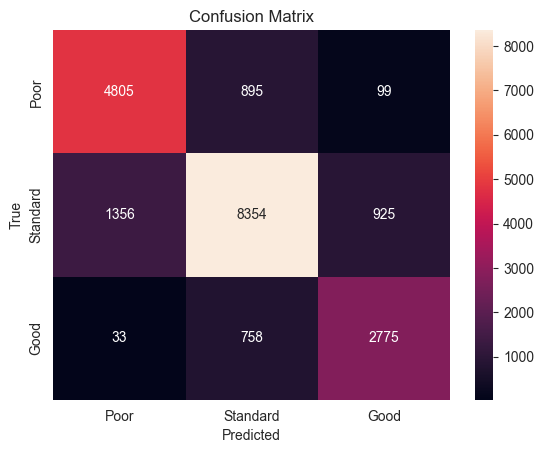

In [31]:
cm = confusion_matrix(y_val, preds_rf, labels=["Poor", "Standard", "Good"])

sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Poor", "Standard", "Good"],
            yticklabels=["Poor", "Standard", "Good"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Macierz pomyłek pokazuje, że:
- większość obserwacji klasy **Standard** jest klasyfikowana poprawnie,
- błędy najczęściej występują pomiędzy klasami sąsiadującymi (*Poor ↔ Standard*, *Standard ↔ Good*),
- bardzo rzadko dochodzi do bezpośredniej pomyłki między skrajnymi klasami (*Poor ↔ Good*).

Taki rozkład błędów jest intuicyjny i akceptowalny w kontekście problemu oceny ryzyka kredytowego.

### Wpływ strojenia hiperparametrów

Zastosowanie GridSearchCV pozwoliło poprawić wynik **macro F1 z ~0.75 do ~0.79**.
Największa poprawa dotyczyła:
- recall dla klasy **Good**,
- stabilności predykcji dla klasy **Poor**.

Potwierdza to zasadność strojenia hiperparametrów oraz wykorzystania wag klas (`class_weight='balanced'`)
w przypadku niezbalansowanych danych.

In [28]:
joblib.dump(best_rf, "../models/best_rf_pipeline.joblib")

['../models/best_rf_pipeline.joblib']

In [29]:
model_info = {
    "model": "RandomForestClassifier (Pipeline)",
    "best_params": grid.best_params_,
    "cv_macro_f1": grid.best_score_,
    "val_macro_f1": f1_score(y_val, preds_rf, average="macro"),
    "val_accuracy": accuracy_score(y_val, preds_rf)
}

with open("../models/best_rf_metadata.json", "w") as f:
    json.dump(model_info, f, indent=4)

### Podsumowanie etapu modelowania

Najlepszym modelem okazał się **Random Forest po strojeniu hiperparametrów**,
który zapewnia najlepszy kompromis pomiędzy jakością predykcji wszystkich klas
a stabilnością wyników.

Model ten został wykorzystany w dalszej części projektu (interpretacja modelu – SHAP).